# Загрузка датасета STL10

In [103]:
import torchvision.datasets as datasets

train_dataset = datasets.STL10(root='./data', split = "train", download = True)
test_dataset = datasets.STL10(root='./data', split = "test", download = True)

Files already downloaded and verified
Files already downloaded and verified


In [104]:
len(train_dataset)

5000

In [105]:
len(test_dataset)

8000

# Создание класса Dataset

In [106]:
import torch
import torchvision.transforms as transforms

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(96),
            transforms.CenterCrop(96),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [107]:
train_dataset = CustomImageDataset(train_dataset)
test_dataset = CustomImageDataset(test_dataset)

# Описание датасета

In [108]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, labels, class_labels):
    fig, axes = plt.subplots(1, 5, figsize=(8, 8))
    axes = axes.ravel()
    for i in range(5):
        image = np.transpose(images[i], (1, 2, 0))  
        axes[i].imshow((((image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]) * 255).astype(np.uint8))
        axes[i].set_title(class_labels[labels[i]])
        axes[i].axis('off')
    image = np.transpose(images[i], (1, 2, 0))  
    plt.subplots_adjust(hspace=0.0)
    plt.show()

In [109]:
random_indexes = np.random.randint(0, len(train_dataset), size = 10)
random_images = [np.array(train_dataset[i][0]) for i in random_indexes]
random_labels = [train_dataset[i][1] for i in random_indexes]

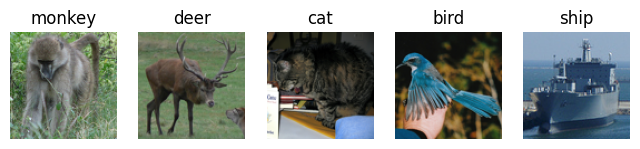

In [110]:
labels = train_dataset.dataset.classes
show_images(random_images, random_labels, labels)

In [111]:
len(labels) # всего классов

10

In [112]:
labels

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

# Оформление датасета в  Dataloader

In [113]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=False)

# Реализация и тренировка нейронной сети

In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [115]:
import torch.nn as nn
import torch.optim as optim

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
        )
        self.layer4 = nn.Sequential(
            nn.Dropout2d(), 
            nn.Linear(9216, 1024),
            nn.ELU(),
            nn.Linear(1024 , 10),
        )
      
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, 1)
        x = self.layer4(x)
        return x  


In [116]:
def train_model(model, criterion, optimizer, trainloader, num_epochs=5):
    for epoch in range(num_epochs):
      train_loss = 0.0
      correct = 0
      total = 0
      accuracy = 0
      loss = 0

      for images, labels in train_dataloader:
          optimizer.zero_grad()
          images = images.to(device)
          labels = labels.to(device)
          
          outputs = model(images)
          loss = criterion(outputs, labels)
          # loss_list.append(loss.item())

          loss.backward()
          optimizer.step()


          train_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      loss = train_loss / len(train_dataloader)
      accuracy = 100 * correct / total
      print(f'Epoch [{epoch + 1}/{num_epochs}] | Loss: {loss:.4f} | Accuracy: {accuracy:.2f}%')
    print('Finished Training')
    
    return model, loss, accuracy

In [124]:
model = NN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [125]:
trained_model, res_loss, res_acc = train_model(model, criterion, optimizer, train_dataloader, num_epochs=7)
# 30~
# 15

Epoch [1/7] | Loss: 2.2515 | Accuracy: 38.92%
Epoch [2/7] | Loss: 1.0533 | Accuracy: 61.56%
Epoch [3/7] | Loss: 0.7537 | Accuracy: 73.74%
Epoch [4/7] | Loss: 0.5000 | Accuracy: 82.34%
Epoch [5/7] | Loss: 0.3666 | Accuracy: 87.08%
Epoch [6/7] | Loss: 0.1989 | Accuracy: 93.10%
Epoch [7/7] | Loss: 0.1834 | Accuracy: 93.78%
Finished Training


In [121]:
def all_accuracy(model, testloader):
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Loss: {test_loss / len(test_dataloader):.4f} | Test Accuracy: {100 * correct/total:.2f}%')

In [122]:
all_accuracy(trained_model, test_dataloader)

Test Loss: 1.9224 | Test Accuracy: 58.27%


In [126]:
def class_accuracy(model, testloader):
    model.eval()

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of {} : {} %'.format(
            i, 100 * class_correct[i] / class_total[i]))

In [128]:
class_accuracy(trained_model, test_dataloader)

Accuracy of 0 : 74.0 %
Accuracy of 1 : 43.54838709677419 %
Accuracy of 2 : 77.3109243697479 %
Accuracy of 3 : 36.8 %
Accuracy of 4 : 66.93548387096774 %
Accuracy of 5 : 33.333333333333336 %
Accuracy of 6 : 59.02777777777778 %
Accuracy of 7 : 53.9568345323741 %
Accuracy of 8 : 71.42857142857143 %
Accuracy of 9 : 59.32203389830509 %


In [129]:
labels = train_dataset.dataset.classes

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_predictions(model, dataloader, class_labels, num_images=8):
    model.eval()
    
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_images]
    labels = labels[:num_images]
    
    model = model.to(device)
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
    
    predicted = predicted.cpu()
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    fig.tight_layout ()
    for i in range(num_images):
        image = images[i].cpu().numpy().transpose((1, 2, 0))
        label = class_labels[labels[i].item()]
        prediction = class_labels[predicted[i].item()]
        
        axes[i].imshow((((image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]) * 255).astype(np.uint8))
        axes[i].set_title(f'True: {label}\nPredicted: {prediction}')
        axes[i].axis('off')
      
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that d

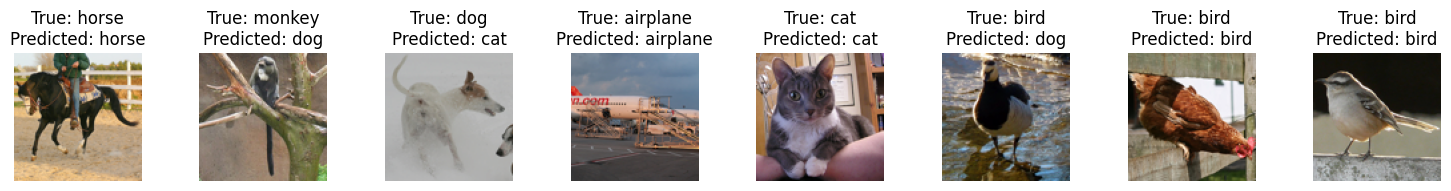

In [131]:
labels = train_dataset.dataset.classes
show_predictions(trained_model, test_dataloader, labels)

# Transfer Learning

In [132]:
from torchvision import models
import torchvision

model_ft  = torchvision.models.resnet152(pretrained=True)
for param in model_ft .parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.ELU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ELU(),
    torch.nn.Linear(512 , 10),
)

model_tl = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tl.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [133]:
model_ft, res_loss, res_acc = train_model(model_ft, criterion, optimizer, train_dataloader, num_epochs=6)

Epoch [1/6] | Loss: 0.8247 | Accuracy: 71.88%
Epoch [2/6] | Loss: 0.5396 | Accuracy: 80.94%
Epoch [3/6] | Loss: 0.4597 | Accuracy: 83.84%
Epoch [4/6] | Loss: 0.4380 | Accuracy: 84.74%
Epoch [5/6] | Loss: 0.4011 | Accuracy: 85.82%
Epoch [6/6] | Loss: 0.3631 | Accuracy: 86.92%
Finished Training


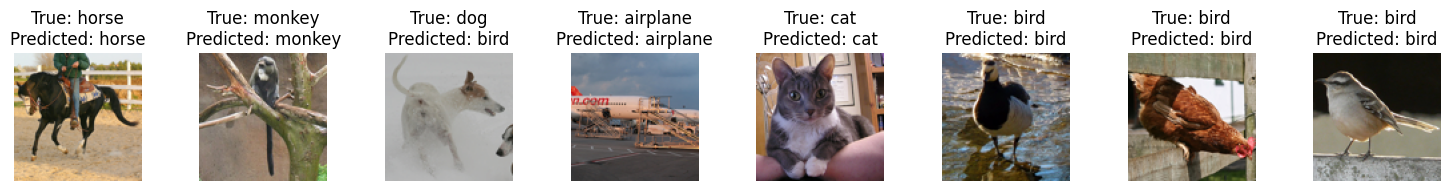

In [134]:
labels = train_dataset.dataset.classes
show_predictions(model_ft, test_dataloader, labels)

In [135]:
all_accuracy(model_ft, test_dataloader)

Test Loss: 0.5590 | Test Accuracy: 81.38%


In [136]:
class_accuracy(model_ft, test_dataloader)

Accuracy of 0 : 73.0 %
Accuracy of 1 : 89.51612903225806 %
Accuracy of 2 : 77.3109243697479 %
Accuracy of 3 : 66.4 %
Accuracy of 4 : 67.74193548387096 %
Accuracy of 5 : 68.1159420289855 %
Accuracy of 6 : 93.75 %
Accuracy of 7 : 89.92805755395683 %
Accuracy of 8 : 78.99159663865547 %
Accuracy of 9 : 89.83050847457628 %




# Вывод



Для исходной модели были получены такие результаты на тестовой выборке

Test Loss: 1.9224 | Test Accuracy: 58.27%


Для модели полученной с помощью Transfer Learning

Test Loss: 0.5590 | Test Accuracy: 81.38%


Можно сделать вывод, что вторая модель(архитектура resnet152) справилась с распознованием изображений значительно лучше, чем первая